![title](images/title.png)

![intro](images/intro.png)

Anime, originating in late 19th-century Japan, has become a global entertainment phenomenon, captivating audiences worldwide. However, with the rapid expansion of anime titles, discovering relevant content can be overwhelming for viewers. To address this challenge, we aim to develop an **anime recommender system** that simplifies content discovery and enhances the user experience.  

## Project Objective  
The goal of this project is to design a system that suggests anime shows and movies tailored to individual preferences.  

To achieve this, we:  
- Focused on building a **content-based recommendation system**.  
- Sourced the dataset from **Kaggle**.  
- Used **cosine similarity** to compare anime features and identify relevant titles.  

## How It Works  
- **Content-based filtering**: The system analyzes the features of anime that a user has previously enjoyed.  
- **Cosine similarity**: Measures the closeness between content features to recommend titles that align with a user’s interests.  

## Outcome  
Our recommender system aims to:  
- Streamline the anime discovery process.
- Help users navigate the vast anime landscape.
- Suggest personalized titles that match individual tastes.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

![dataset](images/dataset.png)

The data used in this project was obtained from **Kaggle** and consists of two datasets: **User Data** and **Anime Data**. Together, they provide detailed information on user preferences, ratings, and anime features.  

## User Data  
- **Size**: 7.8 million entries of user ratings  
- **Features**:  
  - User ID  
  - Anime title  
  - User rating  

## Anime Data  
- **Size**: 12,294 entries describing anime shows and movies  
- **Features**:  
  - **Title**: Name of the anime  
  - **Genres**: Associated genres (e.g., action, comedy, drama)  
  - **Type**: TV show or movie  
  - **Episodes**: Total number of episodes  
  - **Average Rating**: Overall average user rating  
  - **Popularity**: Based on the number of user ratings  

This project contains two dataset, one with the anime rating and the other with information describing the anime itself. Both dataset come from Kaggle with the link provided <br> 
https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=rating.csv

In [8]:
rating_df = pd.read_csv('rating.csv')
anime_df = pd.read_csv('anime.csv')

In [9]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [10]:
rating_df.shape

(7813737, 3)

In [11]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [12]:
rating_df.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [13]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [14]:
anime_df.shape

(12294, 7)

![pre](images/pre.png)

## Pre-Processing Steps  
To prepare the datasets for analysis, the following pre-processing steps were implemented:  

1. **Handling Missing Values**
   - Very few null values were present; these were dropped to maintain data integrity.

2. **Genre Features**  
   - The list of genres was split into:  
     - **Primary genre**  
     - **Secondary genre**  
     - **Tertiary genre**  
   - This allows for better feature separation and analysis.  

3. **Categorical Value Checks**  
   - Evaluated for uniqueness and redundancy to ensure data quality.  

4. **Summary Statistics**  
   - Analyzed for abnormalities to identify potential issues in the data.  

5. **Outlier Removal**  
   - Removed outliers in the lower quartile of the "member" feature.  
   - This step ensures the system focuses on relevant and popular titles.  

By cleaning and organizing the data, we ensured that the final dataset was ready for building an effective recommendation system.  

In [17]:
anime_df = anime_df.dropna()

In [18]:
anime_df.isna().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

In [19]:
genre_split = anime_df['genre'].str.split(',', expand=True)

anime_df['genre_1'] = genre_split[0].str.strip().str.lower()
anime_df['genre_2'] = genre_split[1].str.strip().str.lower()
anime_df['genre_3'] = genre_split[2].str.strip().str.lower()

In [20]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,genre_1,genre_2,genre_3
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,drama,romance,school
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,action,adventure,drama
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,action,comedy,historical
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,sci-fi,thriller,None
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,action,comedy,historical


In [21]:
anime_df['genre_1'].unique()

array(['drama', 'action', 'sci-fi', 'comedy', 'adventure', 'fantasy',
       'mystery', 'psychological', 'ecchi', 'josei', 'military',
       'romance', 'demons', 'dementia', 'music', 'game', 'cars', 'mecha',
       'horror', 'school', 'historical', 'kids', 'shounen', 'shoujo',
       'magic', 'harem', 'martial arts', 'sports', 'slice of life',
       'seinen', 'parody', 'police', 'thriller', 'supernatural',
       'samurai', 'super power', 'vampire', 'space', 'hentai', 'yaoi'],
      dtype=object)

In [22]:
anime_df['genre_2'].unique()

array(['romance', 'adventure', 'comedy', 'thriller', 'drama', 'military',
       'fantasy', 'school', 'music', 'slice of life', 'mecha', 'mystery',
       'horror', 'police', 'parody', 'seinen', 'psychological', 'sci-fi',
       'demons', 'historical', 'sports', 'supernatural', 'game', 'magic',
       'josei', 'shounen', 'harem', 'cars', 'dementia', None, 'shoujo',
       'kids', 'samurai', 'ecchi', 'shoujo ai', 'super power',
       'martial arts', 'shounen ai', 'space', 'vampire', 'hentai', 'yaoi',
       'yuri'], dtype=object)

In [23]:
anime_df['genre_3'].unique()

array(['school', 'drama', 'historical', None, 'shounen', 'sci-fi',
       'romance', 'mecha', 'supernatural', 'military', 'comedy', 'parody',
       'fantasy', 'shoujo', 'mystery', 'psychological', 'sports',
       'seinen', 'horror', 'josei', 'slice of life', 'music',
       'shounen ai', 'ecchi', 'demons', 'magic', 'vampire', 'police',
       'martial arts', 'space', 'super power', 'dementia', 'shoujo ai',
       'thriller', 'harem', 'kids', 'samurai', 'game', 'cars', 'yaoi',
       'hentai', 'yuri'], dtype=object)

In [24]:
anime_df['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA'], dtype=object)

In [25]:
df = anime_df
anime_df.describe()

,anime_id,rating,members
count,12017.000000,12017.000000,1.201700e+04
mean,13638.001165,6.478264,1.834888e+04
std,11231.076675,1.023857,5.537250e+04
min,1.000000,1.670000,1.200000e+01
25%,3391.000000,5.890000,2.250000e+02
50%,9959.000000,6.570000,1.552000e+03
75%,23729.000000,7.180000,9.588000e+03
max,34519.000000,10.000000,1.013917e+06


In [26]:
def removeOutliers(df, column, lower_quartile=0.25, upper_quartile=0.75, multiplier=1.5, direction='both'):
    """
    Removes outliers from a DataFrame based on the IQR method for a specified column.
    
    Parameters:
    - df (DataFrame): The DataFrame to process.
    - column (str): The column to assess for outliers.
    - lower_quartile (float): The lower quartile (default: 0.25).
    - upper_quartile (float): The upper quartile (default: 0.75).
    - multiplier (float): The multiplier for the IQR (default: 1.5).
    - direction (str): 'both', 'low', or 'high' to specify which outliers to remove.
    
    Returns:
    - DataFrame: A new DataFrame with outliers removed.
    """
    # Calculate the quartiles and IQR
    Q1 = df[column].quantile(lower_quartile)
    Q3 = df[column].quantile(upper_quartile)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - (multiplier * IQR)
    upper_bound = Q3 + (multiplier * IQR)
    
    # Filter based on direction
    if direction == 'low':
        return df[df[column] >= lower_bound]
    elif direction == 'high':
        return df[df[column] <= upper_bound]
    else:
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


In [27]:
anime_df = removeOutliers(anime_df, column='members', direction='low')

![visual](images/visual.png)


The visualizatio belowns provide critical insights into the anime dataset, revealing patterns in popularity, user behavior, genres, and episode distributions. These findings help inform the development of an effective recommender system.  

## 1. Top 10 Anime by Members  
- **Insight**:  
   The most popular anime titles based on the number of users ("members") who rated them are:  
   1. **Death Note** (~1 million members)  
   2. **Shingeki no Kyojin (Attack on Titan)** (~900,000 members)  
   3. **Sword Art Online** (~900,000 members)  
- These popular titles highlight the widespread appeal of action, thriller, and fantasy genres.  

## 2. Members vs. Ratings  
- **Insight**:  
   - Anime with **fewer members** show a **wider range of ratings**, indicating variability due to niche audiences.  
   - As membership increases, ratings stabilize, and higher member counts tend to correlate with **favorable ratings**.  
- This suggests that highly-rated anime are more likely to attract larger audiences over time.  

## 3. Genre Popularity (Cumulative)  
- **Insight**:  
   - **Comedy, Action, and Adventure** dominate as the most common genres.  
   - Less frequent genres include **Vampire, Thriller, and Dementia**, reflecting their niche nature.  
- Understanding the genre distribution provides context for the recommender system’s genre-based suggestions.  

## 4. Genre Countplots (Primary, Secondary, Tertiary)  
- **Insight**:  
   - **Primary genres** like Comedy, Action, and Adventure appear most frequently.  
   - **Secondary and Tertiary genres** reveal significant variety, with genres such as **Fantasy, Drama, and Slice of Life** showing strong representation.  
- Analyzing genre layers ensures a granular understanding of anime content features.  

## 5. Boxplot of Episodes  
- **Insight**:  
   - Most anime have **fewer episodes**, with a concentration around single-episode content (Movies) and short series.  
   - Outliers with very high episode counts exist, reflecting longer-running TV series.  
- This skewed distribution aligns with the prevalence of movies, short films, and limited-series anime in the dataset.  

## 6. Number of Ratings per User  
- **Insight**:  
   - The vast majority of users rate a **small number of anime**, with very few users contributing a large volume of ratings.  
- This highlights the presence of a core group of highly active users, which could influence dataset’s overall trends.  

## 7. 2x2 Distribution Plots (Pre and Post Episode Categorization)  
- **Insight**:  
   - Before categorization, the episode distribution was **highly skewed**.  
   - By introducing categories:  
     - **Movie/Short Film** (1 episode)  
     - **<=12 Episodes** (Limited series)  
     - **<=24 Episodes** (Standard series)  
     - **>24 Episodes** (Long series),  
     the data became more interpretable, revealing that **shorter content dominates**.  

## 8. Correlation Matrix  
- **Insights**:  
   - **Members** and **Ratings** show a moderate positive correlation (**0.39**), suggesting that larger audiences tend to rate popular anime favorably.  
   - The number of **Episodes** has weak correlations with both Ratings (**0.088**) and Members (**0.056**), indicating little influence on popularity or ratings.  
- These relationships provide a quantitative understanding of how features like ratings and audience size interact.  

## Summary  
The visualizations highlight key patterns in the dataset:  
- Popular anime attract large audiences and tend to have stable, favorable ratings.  
- Comedy, Action, and Adventure dominate the genre space.  
- Shorter anime (movies and limited series) are far more prevalent.  
- User ratings are heavily skewed, with most users rating only a small number of titles.  

These insights provide a strong foundation for building a **content-based recommender system** capable of understanding user preferences and suggesting relevant anime.  


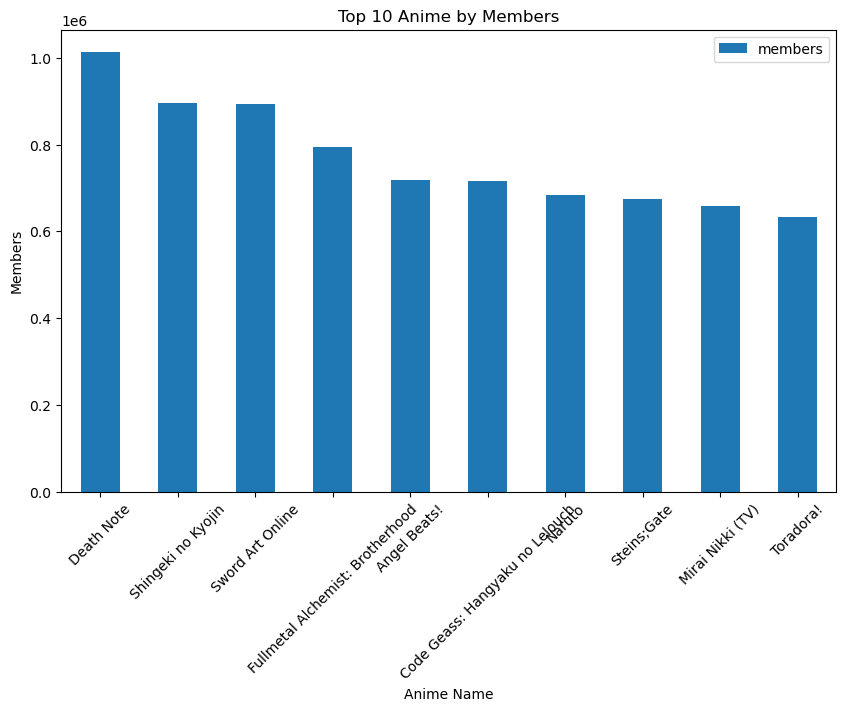

In [30]:
# Top 10 most popular anime by members
top_anime = df[['name', 'members']].drop_duplicates().sort_values(by='members', ascending=False).head(10)
top_anime.plot(x='name', y='members', kind='bar', figsize=(10, 6), title='Top 10 Anime by Members')
plt.xlabel('Anime Name')
plt.ylabel('Members')
plt.xticks(rotation=45)
plt.show()

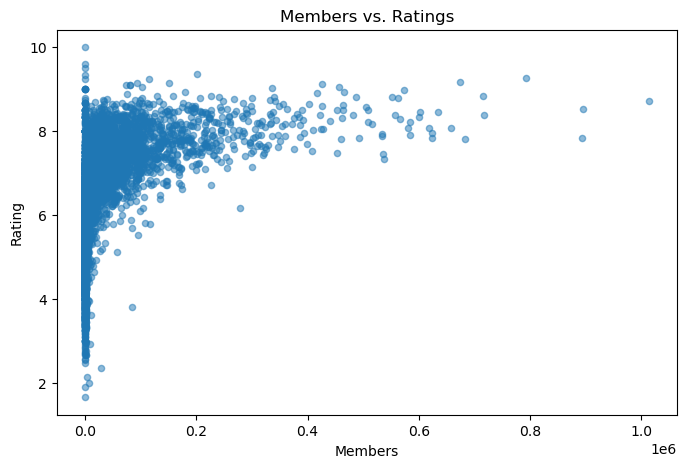

In [31]:
# Scatter plot
anime_df.plot.scatter(x='members', y='rating', alpha=0.5, figsize=(8, 5), title='Members vs. Ratings')
plt.xlabel('Members')
plt.ylabel('Rating')
plt.show()

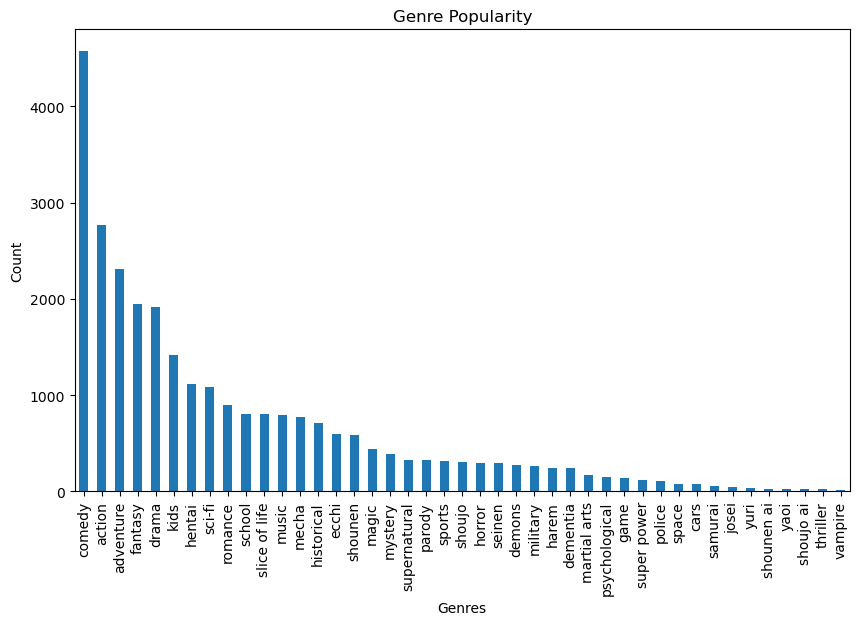

In [32]:
genres = pd.concat([df['genre_1'], df['genre_2'], df['genre_3']]).dropna()
genre_counts = genres.value_counts()

genre_counts.plot(kind='bar', figsize=(10, 6), title='Genre Popularity')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

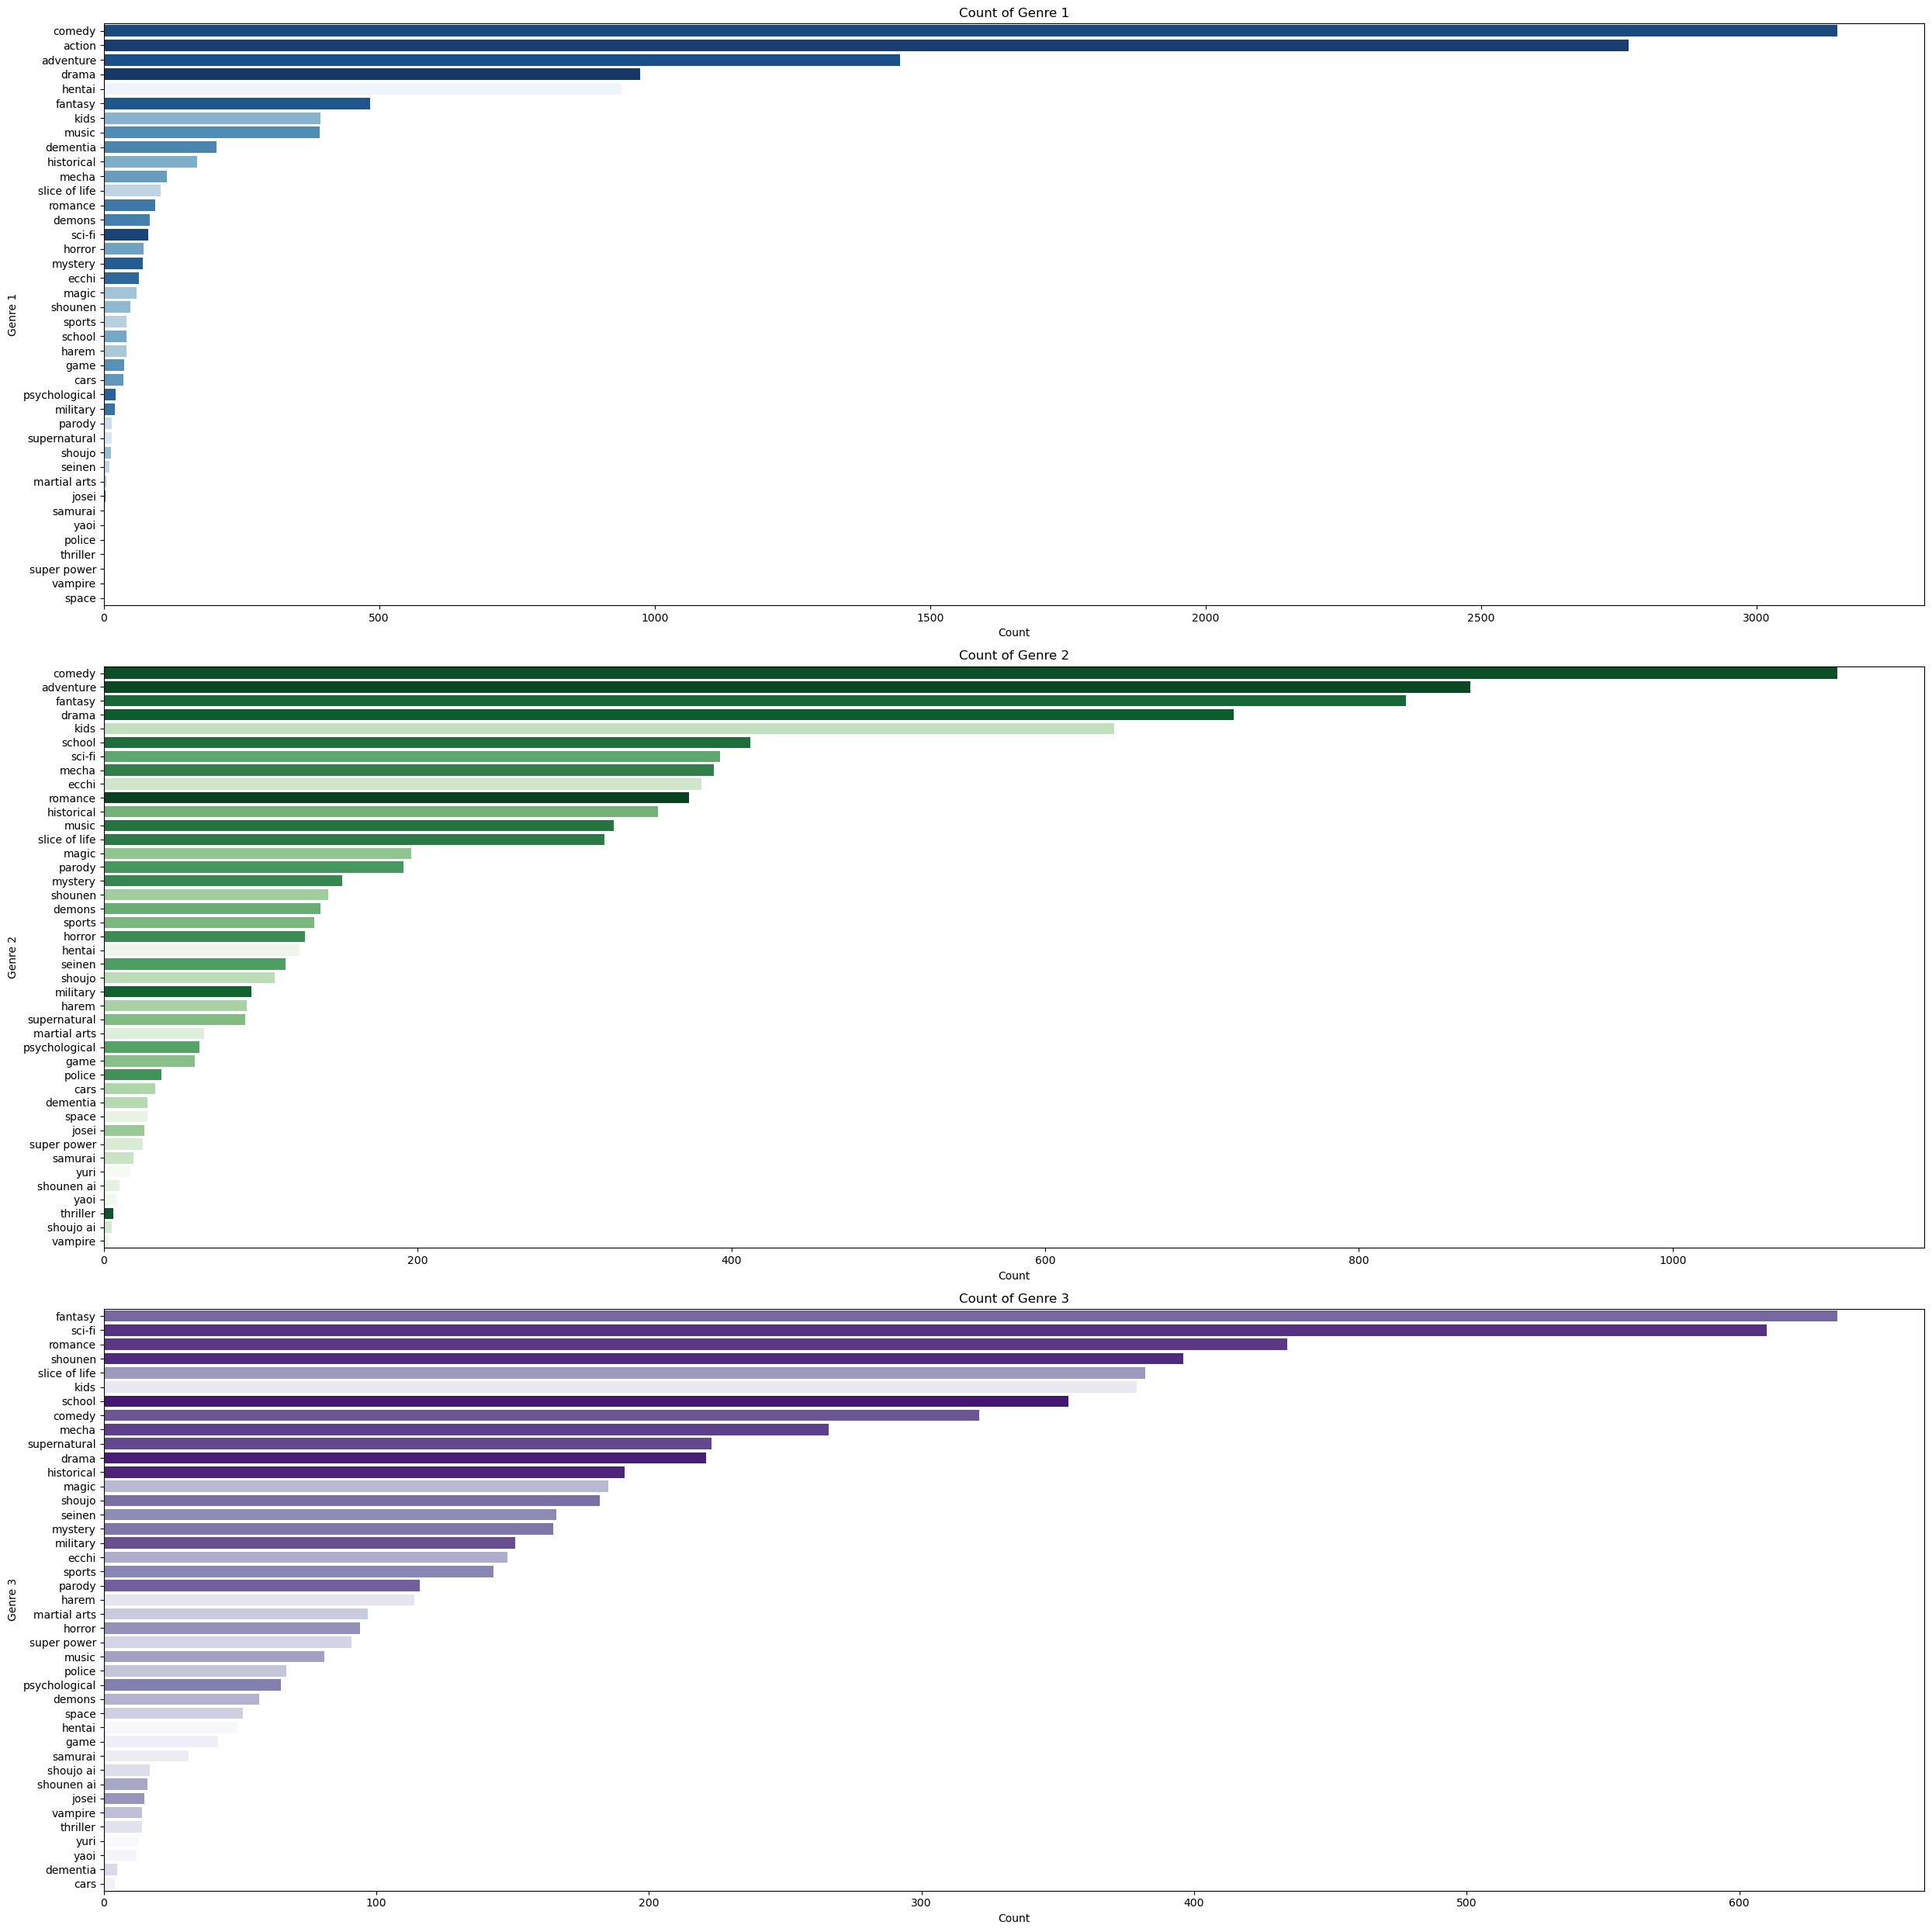

In [33]:
# Set up a figure with subplots (1 plot per row)
fig, axes = plt.subplots(3, 1, figsize=(25, 25))  # 3 rows, 1 column

# Countplot for genre_1
sns.countplot(data=df, y='genre_1', ax=axes[0], order=df['genre_1'].value_counts().index, palette='Blues_r', hue=df['genre_1'], legend=False)
axes[0].set_title('Count of Genre 1')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Genre 1')


# Countplot for genre_2
sns.countplot(data=df, y='genre_2', ax=axes[1], order=df['genre_2'].value_counts().index, palette='Greens_r', hue=df['genre_2'], legend=False)
axes[1].set_title('Count of Genre 2')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Genre 2')


# Countplot for genre_3
sns.countplot(data=df, y='genre_3', ax=axes[2], order=df['genre_3'].value_counts().index, palette='Purples_r', hue=df['genre_3'], legend=False)
axes[2].set_title('Count of Genre 3')
axes[2].set_xlabel('Count')
axes[2].set_ylabel('Genre 3')


# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


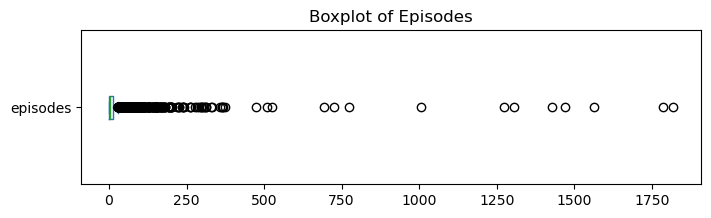

In [34]:
# Boxplot
df['episodes'] = pd.to_numeric(df['episodes'], errors='coerce')
df['episodes'].plot(kind='box', vert=False, figsize=(8, 2), title='Boxplot of Episodes')
plt.show()

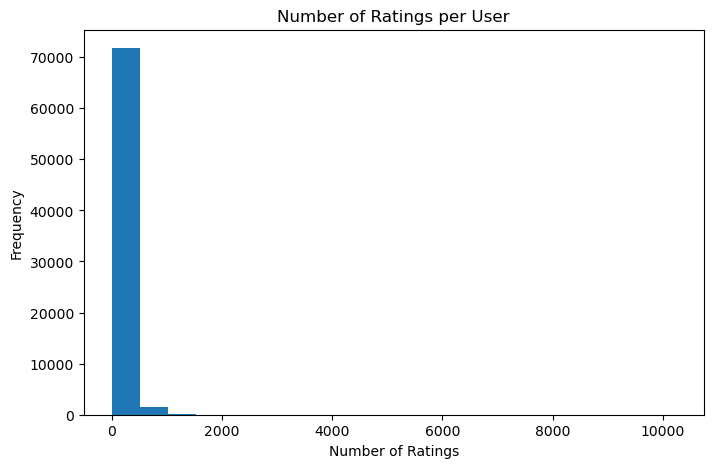

In [35]:
# Ratings per user
user_ratings = rating_df.groupby('user_id')['anime_id'].count()
user_ratings.plot(kind='hist', bins=20, figsize=(8, 5), title='Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.show()

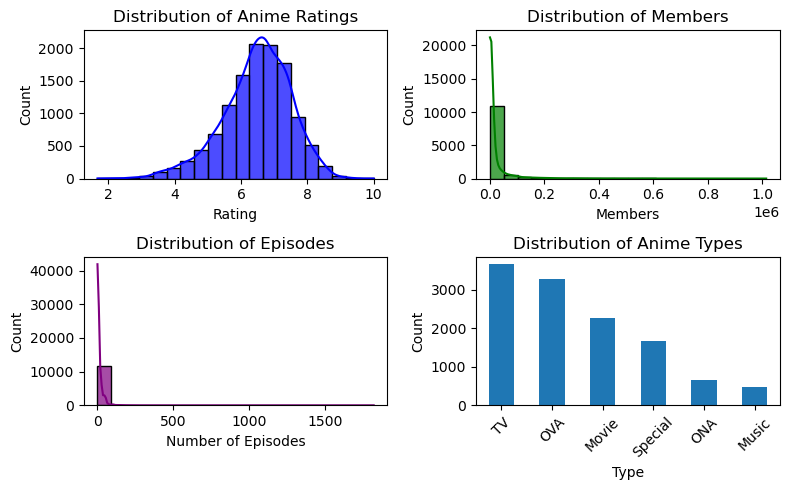

In [36]:
# Set up a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid of subplots

# Histogram and KDE for Rating Distribution (rating_y)
sns.histplot(df['rating'], bins=20, kde=True, ax=axes[0, 0], color='blue', alpha=0.7)
axes[0, 0].set_title('Distribution of Anime Ratings')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')

# Histogram and KDE for Members Distribution
sns.histplot(df['members'], bins=20, kde=True, ax=axes[0, 1], color='green', alpha=0.7)
axes[0, 1].set_title('Distribution of Members')
axes[0, 1].set_xlabel('Members')
axes[0, 1].set_ylabel('Count')

# Histogram and KDE for Episodes Distribution
sns.histplot(df['episodes'].dropna(), bins=20, kde=True, ax=axes[1, 0], color='purple', alpha=0.7)
axes[1, 0].set_title('Distribution of Episodes')
axes[1, 0].set_xlabel('Number of Episodes')
axes[1, 0].set_ylabel('Count')

# Bar Chart for Type Distribution (no KDE)
type_counts = df['type'].value_counts()
type_counts.plot(kind='bar', figsize=(8, 5), title='Distribution of Anime Types')
axes[1, 1].set_xlabel('Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()


In [37]:
def categorize_content(row):
    if   row['episodes'] == 1: return 'Movie/Short Film'
    elif row['episodes'] <= 12: return '<=12 Episodes'
    elif row['episodes'] <= 24: return '<=24 Episodes'
    else: return '>24 Episodes'

df['episodes_categorical'] = df.apply(categorize_content, axis=1)

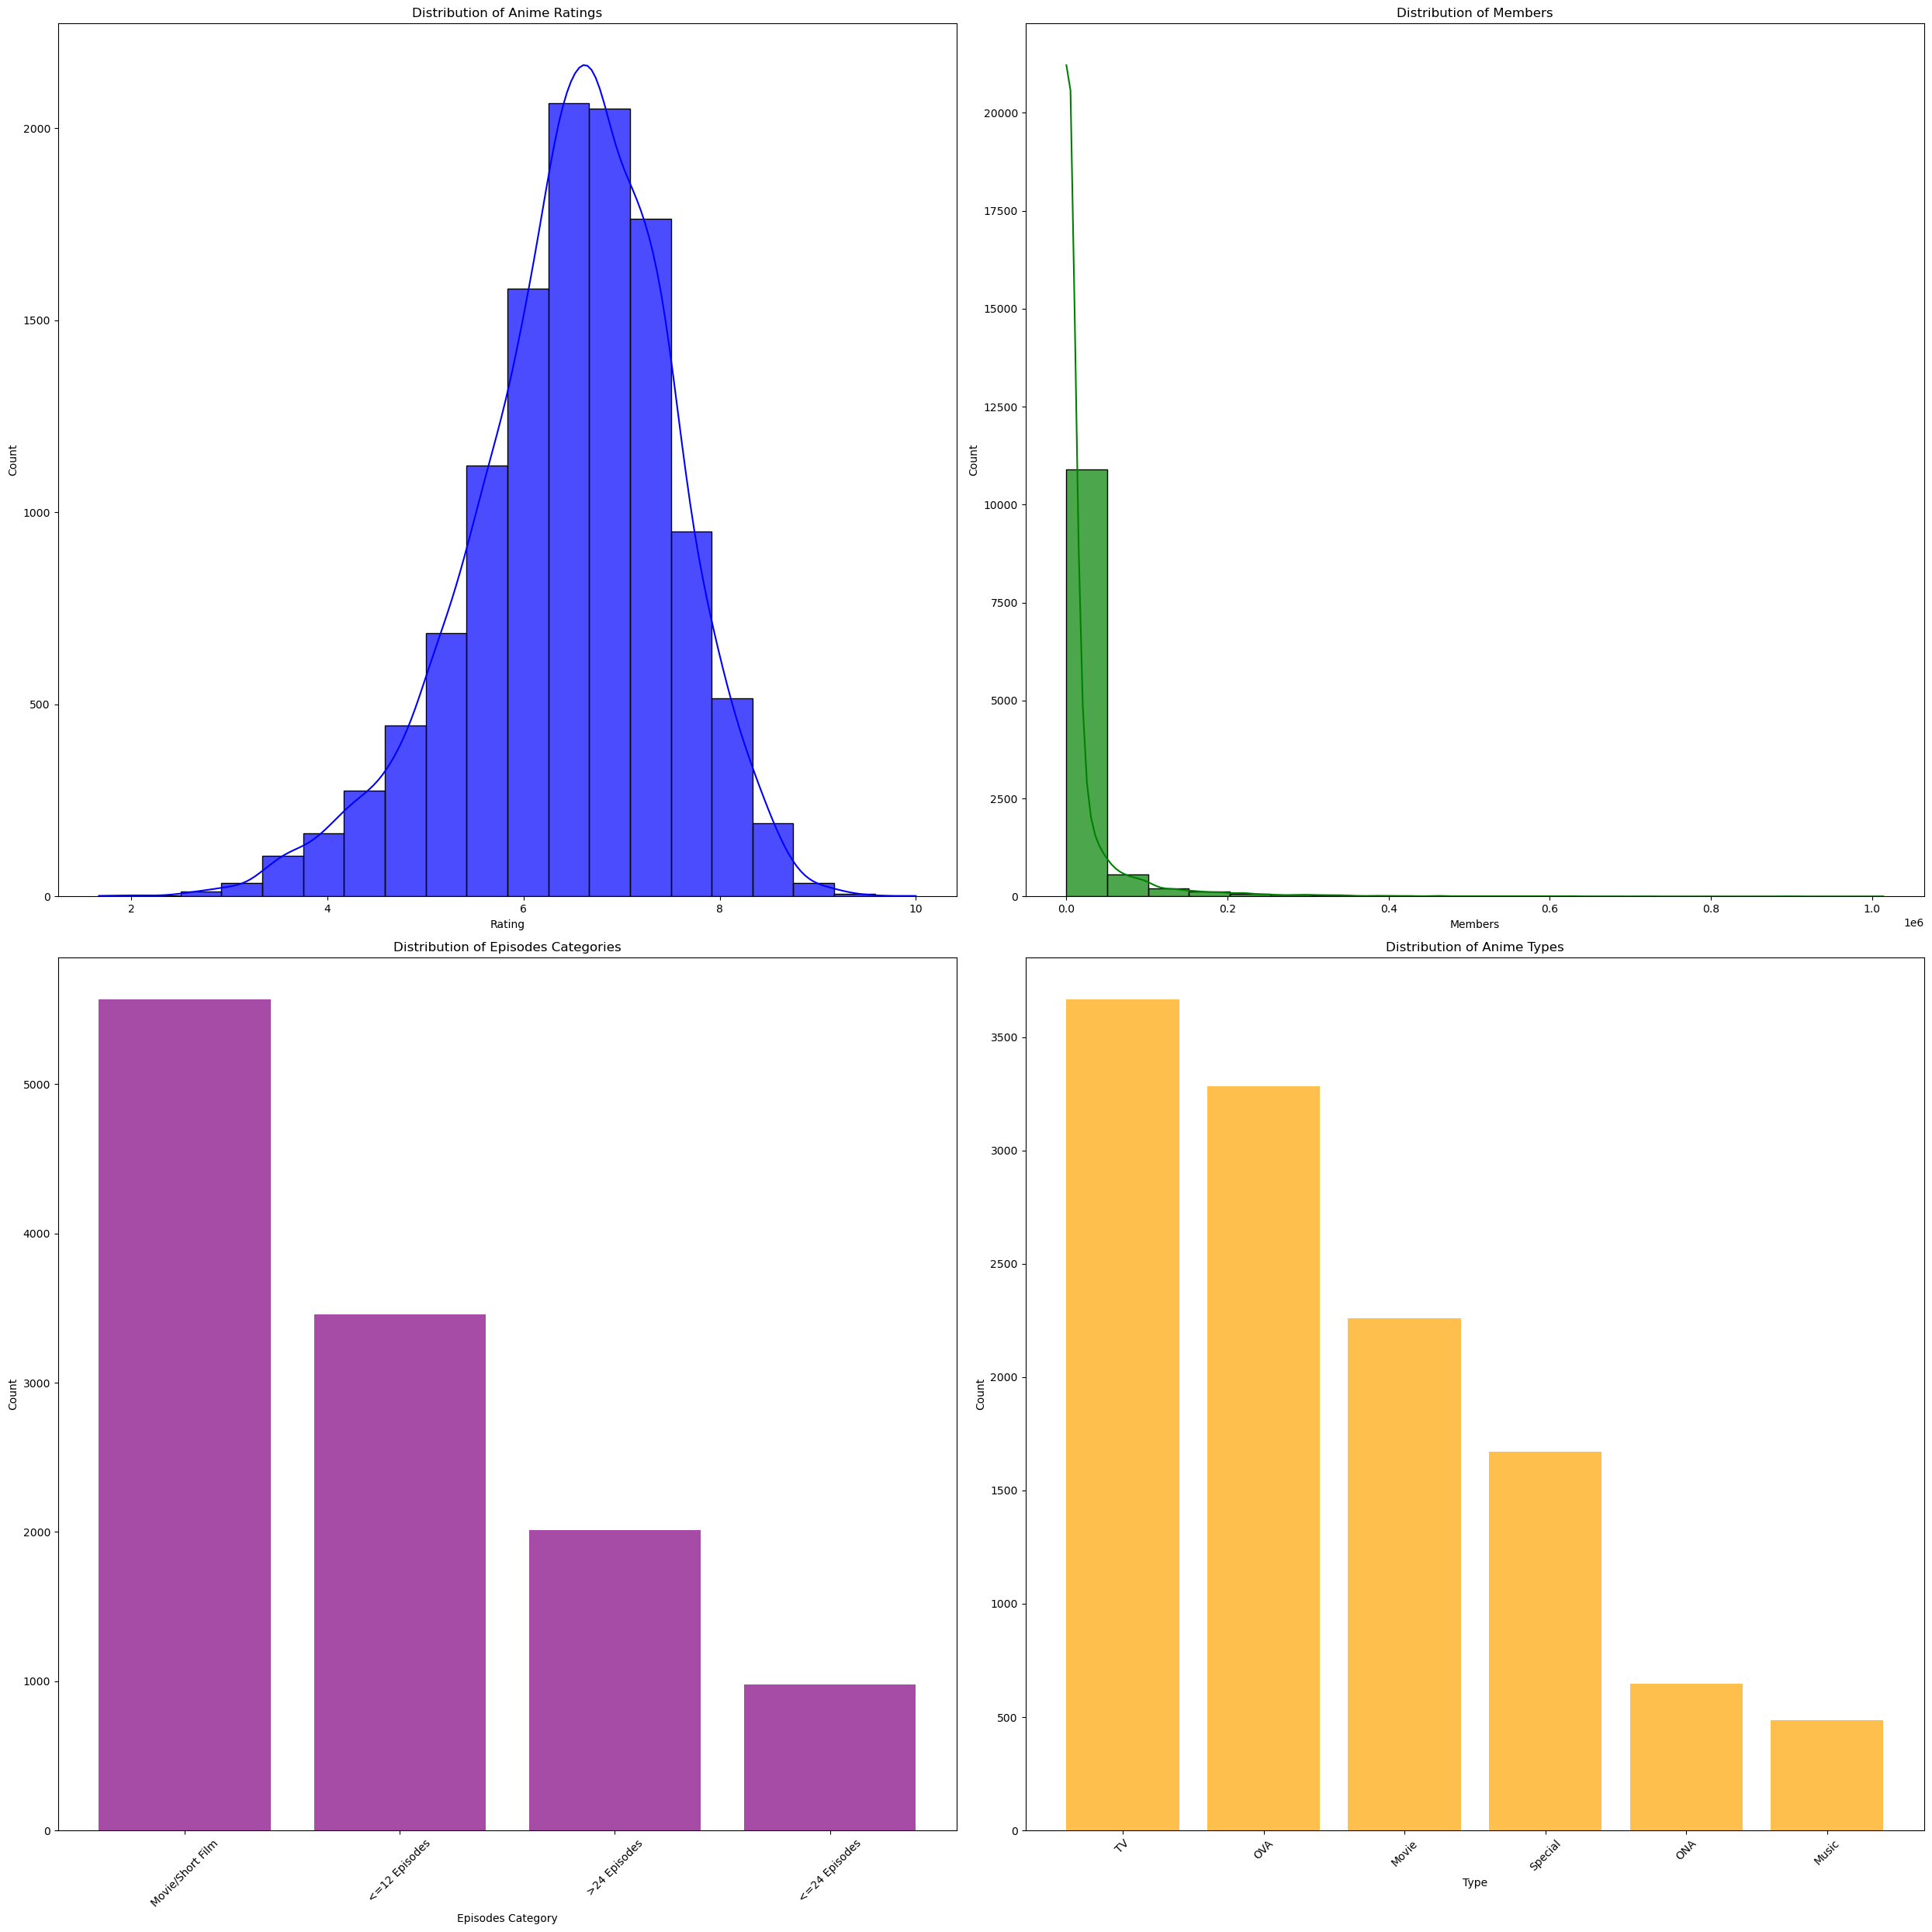

In [38]:
# Set up a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(25, 25))  # 2x2 grid of subplots

# Histogram and KDE for Rating Distribution (rating_y)
sns.histplot(df['rating'], bins=20, kde=True, ax=axes[0, 0], color='blue', alpha=0.7)
axes[0, 0].set_title('Distribution of Anime Ratings')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Count')

# Histogram and KDE for Members Distribution
sns.histplot(df['members'], bins=20, kde=True, ax=axes[0, 1], color='green', alpha=0.7)
axes[0, 1].set_title('Distribution of Members')
axes[0, 1].set_xlabel('Members')
axes[0, 1].set_ylabel('Count')

# Bar Chart for Episodes Categorical Distribution
episodes_counts = df['episodes_categorical'].value_counts()
axes[1, 0].bar(episodes_counts.index, episodes_counts.values, color='purple', alpha=0.7)
axes[1, 0].set_title('Distribution of Episodes Categories')
axes[1, 0].set_xlabel('Episodes Category')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)

# Bar Chart for Type Distribution
type_counts = df['type'].value_counts()
axes[1, 1].bar(type_counts.index, type_counts.values, color='orange', alpha=0.7)
axes[1, 1].set_title('Distribution of Anime Types')
axes[1, 1].set_xlabel('Type')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

In [39]:
df['type'].value_counts()

type
TV         3668
OVA        3284
Movie      2259
Special    1670
ONA         648
Music       488
Name: count, dtype: int64

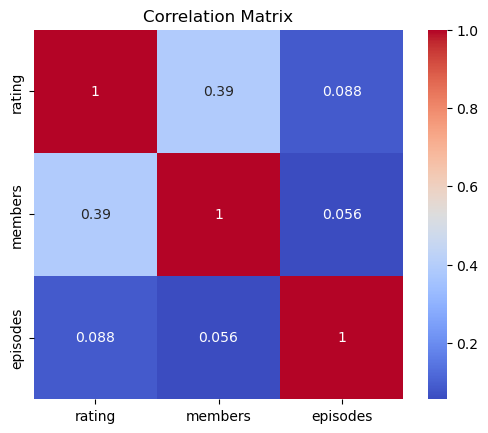

In [40]:
correlation_matrix = df[['rating', 'members', 'episodes']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

![system](images/system.png)

# Modeling  

To build our content-based recommendation system, we transformed features, normalized data, and implemented cosine similarity to identify relevant anime recommendations.

## Feature Transformation  

- **One-Hot Encoding**:  
   Categorical variables were encoded numerically to make them suitable for modeling. The following features were transformed:  
   - **Type**  
   - **Primary, Secondary, and Tertiary Genres**  

- **Encoding Episode Categories**:  
   The number of episodes was encoded to reflect an **ordinal relationship**:  
   - Movie/Short Film → **0**  
   - <=12 Episodes    → **1**  
   - <=24 Episodes    → **2**  
   - \>24 Episodes    → **4**  

   This transformation ensures that shorter content holds a lower numerical value while longer series receive higher values.

# Feature Normalization  
To prevent any single feature from dominating the similarity calculation, all numerical features were normalized.  

Normalization ensures that features are on the same scale, allowing each one to contribute equally to the model.  

# Cosine Similarity  
Cosine similarity was used to measure how similar two anime titles are based on their features.  

**Definition**: Cosine similarity measures the angle between two vectors in a multidimensional space.  

**Range**:  
- **1**: Highly similar  
- **0**: No similarity  

**Formula**:

$Cosine Similarity(x,y) = \frac{x \cdot y}{||x|| \cdot ||y||}$


where:
- $x \cdot y$ is the dot product of vectors $x$ and $y$,
- $||x||$ is the magnitude (norm) of vector $x$,
- $||y||$ is the magnitude (norm) of vector $y$.

# Features Used for Similarity  
The following features were used to compute similarity:  
- **Type**  
- **Number of Episodes** (encoded)  
- **Average Rating**  
- **Popularity**  
- **Primary, Secondary, and Tertiary Genres**  

# Similarity Matrix  
A **similarity matrix** was created to compare each anime title against every other title based on the features above.  

- The matrix stores **pairwise similarity scores** between all titles.  
- These scores form the foundation of our recommendation system.  

# Recommendation Strategy  

The system generates recommendations for each user through the following steps:  

1. **Identify Positively Rated Anime**  
   - Focus on anime titles where the user provided a **rating greater than 7**.  

2. **Generate Recommendations**  
   - For each positively rated anime:  
     - Retrieve the **most similar titles** from the similarity matrix.  
     - Accumulate similarity scores for all suggested anime (weighted recommendations).  

3. **Filter Out Rated Anime**  
   - Exclude anime that the user has already rated to avoid redundancy in recommendations.  

4. **Rank and Select Top Recommendations**  
   - Sort the remaining anime by their accumulated similarity scores.  
   - Select the **top N recommendations** for each user (default: N = 5).

# Implementation  

1. **Refining Feature Names**  
   - Features were redefined and renamed for clarity and ease of processing.  

2. **Calculating Cosine Similarity**  
   - The `cosine_similarity` function was used to compute similarity scores between all anime titles.  

3. **Storing Results**  
   - A **results dictionary** was created to store cosine similarity scores efficiently.  

4. **Generating Recommendations**  
   - A custom function was implemented to:  
     - Identify the **top N most similar anime** for highly rated titles.  
     - Apply user-defined rating thresholds.  
     - Output a **final list of recommendations**.  

# Summary  
By transforming features, standardizing data, and implementing cosine similarity, we developed a robust **content-based recommendation system**.  

The system effectively identifies anime titles that are most similar to those a user enjoys and provides a personalized list of recommendations.  



In [43]:
df.head()

,anime_id,name,genre,type,episodes,rating,members,genre_1,genre_2,genre_3,episodes_categorical
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,drama,romance,school,Movie/Short Film
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,action,adventure,drama,>24 Episodes
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262,action,comedy,historical,>24 Episodes
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572,sci-fi,thriller,None,<=24 Episodes
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266,action,comedy,historical,>24 Episodes


In [44]:
for x in df.columns: print(x)

anime_id
name
genre
type
episodes
rating
members
genre_1
genre_2
genre_3
episodes_categorical


In [45]:
# One-hot encode the categorical features
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[['type', 'genre_1', 'genre_2', 'genre_3']])

# Create a DataFrame for the encoded features
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out())

# Define the mapping
ordinal_mapping = {
    'Movie/Short Film': 0,
    '<=12 Episodes': 1,
    '<=24 Episodes': 2,
    '>24 Episodes': 4
}

# Apply the mapping
df['episodes_categorical'] = df['episodes_categorical'].map(ordinal_mapping)
df = pd.concat([df, one_hot_df], axis=1)


In [46]:
df['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA', nan], dtype=object)

In [47]:
scaler = MinMaxScaler()
df[['episodes', 'rating', 'members']] = scaler.fit_transform(df[['episodes', 'rating', 'members']])

In [48]:
df.head()

,anime_id,name,genre,type,episodes,rating,members,genre_1,genre_2,genre_3,episodes_categorical,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,genre_1_action,genre_1_adventure,genre_1_cars,genre_1_comedy,genre_1_dementia,genre_1_demons,genre_1_drama,genre_1_ecchi,genre_1_fantasy,genre_1_game,genre_1_harem,genre_1_hentai,genre_1_historical,genre_1_horror,genre_1_josei,genre_1_kids,genre_1_magic,genre_1_martial arts,genre_1_mecha,genre_1_military,genre_1_music,genre_1_mystery,genre_1_parody,genre_1_police,genre_1_psychological,genre_1_romance,genre_1_samurai,genre_1_school,genre_1_sci-fi,genre_1_seinen,genre_1_shoujo,genre_1_shounen,genre_1_slice of life,genre_1_space,genre_1_sports,genre_1_super power,genre_1_supernatural,genre_1_thriller,genre_1_vampire,genre_1_yaoi,genre_2_adventure,genre_2_cars,genre_2_comedy,genre_2_dementia,genre_2_demons,genre_2_drama,genre_2_ecchi,genre_2_fantasy,genre_2_game,genre_2_harem,genre_2_hentai,genre_2_historical,genre_2_horror,genre_2_josei,genre_2_kids,genre_2_magic,genre_2_martial arts,genre_2_mecha,genre_2_military,genre_2_music,genre_2_mystery,genre_2_parody,genre_2_police,genre_2_psychological,genre_2_romance,genre_2_samurai,genre_2_school,genre_2_sci-fi,genre_2_seinen,genre_2_shoujo,genre_2_shoujo ai,genre_2_shounen,genre_2_shounen ai,genre_2_slice of life,genre_2_space,genre_2_sports,genre_2_super power,genre_2_supernatural,genre_2_thriller,genre_2_vampire,genre_2_yaoi,genre_2_yuri,genre_2_None,genre_3_cars,genre_3_comedy,genre_3_dementia,genre_3_demons,genre_3_drama,genre_3_ecchi,genre_3_fantasy,genre_3_game,genre_3_harem,genre_3_hentai,genre_3_historical,genre_3_horror,genre_3_josei,genre_3_kids,genre_3_magic,genre_3_martial arts,genre_3_mecha,genre_3_military,genre_3_music,genre_3_mystery,genre_3_parody,genre_3_police,genre_3_psychological,genre_3_romance,genre_3_samurai,genre_3_school,genre_3_sci-fi,genre_3_seinen,genre_3_shoujo,genre_3_shoujo ai,genre_3_shounen,genre_3_shounen ai,genre_3_slice of life,genre_3_space,genre_3_sports,genre_3_super power,genre_3_supernatural,genre_3_thriller,genre_3_vampire,genre_3_yaoi,genre_3_yuri,genre_3_None
0,32281.0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,0.000000,0.924370,0.197867,drama,romance,school,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5114.0,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,0.034673,0.911164,0.782769,action,adventure,drama,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28977.0,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,0.027518,0.909964,0.112683,action,comedy,historical,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0

In [49]:
features = [
    "anime_id", "name", "rating", "members", "episodes_categorical", 
    "type_Movie", "type_Music", "type_ONA", "type_OVA", "type_Special", "type_TV",
    
    "genre_1_action",    "genre_1_adventure",    "genre_1_cars",    "genre_1_comedy",    "genre_1_dementia",    "genre_1_demons",    "genre_1_drama",
    "genre_1_ecchi",    "genre_1_fantasy",    "genre_1_game",    "genre_1_harem",    "genre_1_hentai",    "genre_1_historical",    "genre_1_horror",
    "genre_1_josei",    "genre_1_kids",    "genre_1_magic",    "genre_1_martial arts",    "genre_1_mecha",    "genre_1_military",    "genre_1_music",
    "genre_1_mystery",    "genre_1_parody",    "genre_1_police",    "genre_1_psychological",    "genre_1_romance",    "genre_1_samurai",    "genre_1_school",
    "genre_1_sci-fi",    "genre_1_seinen",    "genre_1_shoujo",    "genre_1_shounen",    "genre_1_slice of life",    "genre_1_space",    "genre_1_sports",
    "genre_1_super power",    "genre_1_supernatural",    "genre_1_thriller",    "genre_1_vampire",    "genre_1_yaoi",
    
    "genre_2_adventure",    "genre_2_cars",    "genre_2_comedy",    "genre_2_dementia",    "genre_2_demons",    "genre_2_drama",    "genre_2_ecchi",
    "genre_2_fantasy",    "genre_2_game",    "genre_2_harem",    "genre_2_hentai",    "genre_2_historical",    "genre_2_horror",    "genre_2_josei",
    "genre_2_kids",    "genre_2_magic",    "genre_2_martial arts",    "genre_2_mecha",    "genre_2_military",    "genre_2_music",    "genre_2_mystery",
    "genre_2_parody",    "genre_2_police",    "genre_2_psychological",    "genre_2_romance",    "genre_2_samurai",    "genre_2_school",    "genre_2_sci-fi",
    "genre_2_seinen",    "genre_2_shoujo",    "genre_2_shoujo ai",    "genre_2_shounen",    "genre_2_shounen ai",    "genre_2_slice of life",
    "genre_2_space",    "genre_2_sports",    "genre_2_super power",    "genre_2_supernatural",    "genre_2_thriller",    "genre_2_vampire",
    "genre_2_yaoi",    "genre_2_yuri",
    
    "genre_3_cars",    "genre_3_comedy",    "genre_3_dementia",    "genre_3_demons",    "genre_3_drama",    "genre_3_ecchi",    "genre_3_fantasy",
    "genre_3_game",    "genre_3_harem",    "genre_3_hentai",    "genre_3_historical",    "genre_3_horror",    "genre_3_josei",    "genre_3_kids",
    "genre_3_magic",    "genre_3_martial arts",    "genre_3_mecha",    "genre_3_military",    "genre_3_music",    "genre_3_mystery",    "genre_3_parody",
    "genre_3_police",    "genre_3_psychological",    "genre_3_romance",    "genre_3_samurai",    "genre_3_school",    "genre_3_sci-fi",    "genre_3_seinen",
    "genre_3_shoujo",    "genre_3_shoujo ai",    "genre_3_shounen",    "genre_3_shounen ai",    "genre_3_slice of life",    "genre_3_space",
    "genre_3_sports",    "genre_3_super power",    "genre_3_supernatural",    "genre_3_thriller",    "genre_3_vampire",    "genre_3_yaoi",    "genre_3_yuri",
]

df = df[features]


In [50]:
df.head()

,anime_id,name,rating,members,episodes_categorical,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV,genre_1_action,genre_1_adventure,genre_1_cars,genre_1_comedy,genre_1_dementia,genre_1_demons,genre_1_drama,genre_1_ecchi,genre_1_fantasy,genre_1_game,genre_1_harem,genre_1_hentai,genre_1_historical,genre_1_horror,genre_1_josei,genre_1_kids,genre_1_magic,genre_1_martial arts,genre_1_mecha,genre_1_military,genre_1_music,genre_1_mystery,genre_1_parody,genre_1_police,genre_1_psychological,genre_1_romance,genre_1_samurai,genre_1_school,genre_1_sci-fi,genre_1_seinen,genre_1_shoujo,genre_1_shounen,genre_1_slice of life,genre_1_space,genre_1_sports,genre_1_super power,genre_1_supernatural,genre_1_thriller,genre_1_vampire,genre_1_yaoi,genre_2_adventure,genre_2_cars,genre_2_comedy,genre_2_dementia,genre_2_demons,genre_2_drama,genre_2_ecchi,genre_2_fantasy,genre_2_game,genre_2_harem,genre_2_hentai,genre_2_historical,genre_2_horror,genre_2_josei,genre_2_kids,genre_2_magic,genre_2_martial arts,genre_2_mecha,genre_2_military,genre_2_music,genre_2_mystery,genre_2_parody,genre_2_police,genre_2_psychological,genre_2_romance,genre_2_samurai,genre_2_school,genre_2_sci-fi,genre_2_seinen,genre_2_shoujo,genre_2_shoujo ai,genre_2_shounen,genre_2_shounen ai,genre_2_slice of life,genre_2_space,genre_2_sports,genre_2_super power,genre_2_supernatural,genre_2_thriller,genre_2_vampire,genre_2_yaoi,genre_2_yuri,genre_3_cars,genre_3_comedy,genre_3_dementia,genre_3_demons,genre_3_drama,genre_3_ecchi,genre_3_fantasy,genre_3_game,genre_3_harem,genre_3_hentai,genre_3_historical,genre_3_horror,genre_3_josei,genre_3_kids,genre_3_magic,genre_3_martial arts,genre_3_mecha,genre_3_military,genre_3_music,genre_3_mystery,genre_3_parody,genre_3_police,genre_3_psychological,genre_3_romance,genre_3_samurai,genre_3_school,genre_3_sci-fi,genre_3_seinen,genre_3_shoujo,genre_3_shoujo ai,genre_3_shounen,genre_3_shounen ai,genre_3_slice of life,genre_3_space,genre_3_sports,genre_3_super power,genre_3_supernatural,genre_3_thriller,genre_3_vampire,genre_3_yaoi,genre_3_yuri
0,32281.0,Kimi no Na wa.,0.924370,0.197867,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5114.0,Fullmetal Alchemist: Brotherhood,0.911164,0.782769,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28977.0,Gintama°,0.909964,0.112683,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9253.0,Steins;Gate,0.900360,0.664323,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [51]:
df.shape

(12284, 134)

In [52]:
df.isna().sum()

anime_id                 267
name                     267
rating                   267
members                  267
episodes_categorical     267
type_Movie               267
type_Music               267
type_ONA                 267
type_OVA                 267
type_Special             267
type_TV                  267
genre_1_action           267
genre_1_adventure        267
genre_1_cars             267
genre_1_comedy           267
genre_1_dementia         267
genre_1_demons           267
genre_1_drama            267
genre_1_ecchi            267
genre_1_fantasy          267
genre_1_game             267
genre_1_harem            267
genre_1_hentai           267
genre_1_historical       267
genre_1_horror           267
genre_1_josei            267
genre_1_kids             267
genre_1_magic            267
genre_1_martial arts     267
genre_1_mecha            267
genre_1_military         267
genre_1_music            267
genre_1_mystery          267
genre_1_parody           267
genre_1_police

In [53]:
df = df.dropna()
df.shape

(11750, 134)

In [54]:
a = df.drop(['anime_id','name'], axis = 1)

In [55]:
cos_sim = cosine_similarity(a, a)

In [56]:
cos_sim

array([[1.        , 0.09734144, 0.08549893, ..., 0.13597682, 0.1359426 ,
        0.36424246],
       [0.09734144, 1.        , 0.89487248, ..., 0.06420726, 0.06414251,
        0.5334037 ],
       [0.08549893, 0.89487248, 1.        , ..., 0.06483866, 0.06482924,
        0.54092918],
       ...,
       [0.13597682, 0.06420726, 0.06483866, ..., 1.        , 0.99999993,
        0.45956866],
       [0.1359426 , 0.06414251, 0.06482924, ..., 0.99999993, 1.        ,
        0.45956873],
       [0.36424246, 0.5334037 , 0.54092918, ..., 0.45956866, 0.45956873,
        1.        ]])

In [57]:
df = df.reset_index(drop=True)

In [58]:
results = {}
for idx, row in df.iterrows():
    similar_indices = cos_sim[idx].argsort()[:-100:-1]
    similar_items = [(cos_sim[idx][i], df['anime_id'].iloc[[i]].tolist()[0]) 
                     for i in similar_indices]     
    results[row['anime_id']] = similar_items[1:]

In [59]:
def get_name(a_id):
    return df[df['anime_id'] == a_id]['name'].tolist()[0].split(' - ')[0] 

In [60]:
get_name(32281)

'Kimi no Na wa.'

In [61]:
def recommend(item_id, N):
    print(f"Recommending {N} anime similar to {get_name(item_id)} ...")
    print("---------------------")
    
    recs = results[item_id][:N]
    for rec in recs:
        print(f"\tRecommended with a score {rec[0]}:\t{get_name(rec[1])} ")

In [62]:
recommend(32281, 5)

Recommending 5 anime similar to Kimi no Na wa. ...
---------------------
	Recommended with a score 0.9966562802776471:	Kokoro ga Sakebitagatterunda. 
	Recommended with a score 0.9928266095002584:	Orange: Mirai 
	Recommended with a score 0.9885058002721566:	X OVA 
	Recommended with a score 0.851645317330446:	Robot King 
	Recommended with a score 0.7914672618823996:	Hotarubi no Mori e 


In [63]:
from collections import defaultdict

def generate_recommendations_for_all_users(N=5, rating=7):
    """
    Generate top N recommendations for all users in the rating_df.
    Args:
        N: Number of recommendations to generate per user.
    Returns:
        user_recommendations: Dictionary with user_id as key and recommendations as values.
    """
    user_recommendations = {}

    # Loop through all unique users
    for user_id in rating_df['user_id'].unique():
        # Get all anime rated positively by the user
        user_ratings = rating_df[rating_df['user_id'] == user_id]
        positive_ratings = user_ratings[user_ratings['rating'] > rating]  # Threshold: rating > 7
        
        recommended_anime = defaultdict(float)
        
        # Generate recommendations if positive ratings exist
        if not positive_ratings.empty:
            for anime_id in positive_ratings['anime_id']:
                if anime_id in results:
                    for score, similar_anime in results[anime_id]:
                        # Accumulate similarity scores (weighted recommendations)
                        recommended_anime[similar_anime] += score

            # Filter out already rated anime
            rated_anime = set(user_ratings['anime_id'])
            final_recommendations = [(anime_id, score) for anime_id, score in recommended_anime.items()
                                     if anime_id not in rated_anime]
            
            # Sort and get top N recommendations
            final_recommendations = sorted(final_recommendations, key=lambda x: x[1], reverse=True)[:N]
            user_recommendations[user_id] = final_recommendations
        else:
            user_recommendations[user_id] = []  # No recommendations for users with no positive ratings
    
    return user_recommendations

all_user_recommendations = generate_recommendations_for_all_users(N=5)

In [64]:
# Print an example
example_user_id = list(all_user_recommendations.keys())[1]
print(f"Top Recommendations for User {example_user_id}:")
for anime_id, score in all_user_recommendations[example_user_id]:
    print(f"\t{get_name(anime_id)} - Score: {score:.4f}")

Top Recommendations for User 2:
	Kuroko no Basket 2nd Season - Score: 0.9998
	Kuroko no Basket 3rd Season - Score: 0.9994
	SKET Dance - Score: 0.9987
	Diamond no Ace - Score: 0.9984
	Sakigake!! Cromartie Koukou - Score: 0.9982


![eval](images/eval.png)


To evaluate the performance of our content-based recommendation system, we used two key metrics: **Coverage** and **Diversity**. These metrics provide insights into how well the system generates recommendations and its ability to promote a variety of content.

## Coverage: 37%  

- **Definition**: Coverage measures the percentage of anime titles that appear in at least one user's recommendations.  
- **Result**: Our system achieved a **coverage score of 36.95%**.  

### Interpretation:  
The score indicates that approximately 37% of the available anime titles are being recommended. This suggests:  
- The system may be **missing anime** that users might enjoy.  
- Users' ratings show a **specific and narrow preference** for certain genres, limiting the diversity of recommendations.  
- A portion of the dataset consists of **poorly rated or reviewed shows**, which are not being recommended by the system.  

---

## Diversity: 0.22  

- **Definition**: Diversity measures how dissimilar the recommended items are within a user's list.  
- **Result**: Our system achieved a **diversity score of 0.2218**.  

### Interpretation:  
The low diversity score suggests that recommendations are **highly similar** to one another and may focus too heavily on specific genres. Potential causes include:  
- The dataset contains **few instances** of diverse features or genres.  
- User ratings in the dataset favor certain genres, such as **comedy, action, adventure, and drama**, which dominate recommendations.  
- The recommendation system itself may have a **bias toward popular genres**, limiting variety.  

---

## Insights  

The system successfully generates recommendations but has the following limitations:  
1. **Bias Toward Popular Genres**:  
   - Recommendations are concentrated in genres such as **comedy, action, adventure, and drama**, which are the most represented genres in the dataset.  

2. **Lack of Diversity**:  
   - The system struggles to promote niche or less popular titles, which may lead to a less varied recommendation experience.  

3. **Moderate Coverage**:  
   - The system captures a moderate portion of the available anime titles but leaves room for improvement to recommend a broader range of shows.  

---

## Recommendations for Improvement  

1. **Enhance Dataset Diversity**:  
   - Include more anime titles and user ratings, especially those from underrepresented genres.  

2. **Adjust Recommendation Logic**:  
   - Implement strategies to increase diversity, such as penalizing over-recommended genres or promoting less common genres.  

3. **Incorporate Additional Features**:  
   - Add more user-centric features, such as **viewing history** or **user demographics**, to improve the variety and accuracy of recommendations.  

4. **Hybrid Recommendation Systems**:  
   - Combine content-based filtering with collaborative filtering to enhance both **coverage** and **diversity** of recommendations.  

---

By evaluating the system with coverage and diversity metrics, we identified opportunities to improve recommendation variety and better serve users with diverse preferences.  


In [67]:
def calculate_coverage(all_user_recommendations, total_items):
    """
    Coverage: Proportion of unique recommended items to total catalog size.
    Args:
        all_user_recommendations: Dictionary of recommendations for all users.
        total_items: Total number of items in the catalog.
    Returns:
        Coverage score.
    """
    recommended_items = set()
    for recommendations in all_user_recommendations.values():
        for anime_id, _ in recommendations:
            recommended_items.add(anime_id)

    coverage = len(recommended_items) / total_items
    return coverage

# Calculate coverage
total_items = len(df['anime_id'].unique())
coverage_score = calculate_coverage(all_user_recommendations, total_items)
print(f"Coverage: {coverage_score:.2%}")


Coverage: 36.95%


In [68]:
def calculate_diversity(all_user_recommendations, feature_matrix):
    """
    Diversity: Measures how dissimilar recommended items are for each user.
    Args:
        all_user_recommendations: Dictionary of recommendations for all users.
        feature_matrix: Matrix of item features (e.g., encoded genres).
    Returns:
        Average diversity score across all users.
    """
    diversity_scores = []

    for recommendations in all_user_recommendations.values():
        recommended_ids = [anime_id for anime_id, _ in recommendations]
        if len(recommended_ids) < 2:
            continue  # Skip users with less than 2 recommendations
        
        # Get feature vectors for recommended items
        indices = [df.index[df['anime_id'] == anime_id][0] for anime_id in recommended_ids]
        selected_features = feature_matrix[indices]
        
        # Compute pairwise cosine similarity
        sim_matrix = cosine_similarity(selected_features)
        np.fill_diagonal(sim_matrix, 0)  # Ignore self-similarity
        
        # Average pairwise similarity
        avg_similarity = np.mean(sim_matrix)
        diversity_scores.append(1 - avg_similarity)  # Higher = more diverse

    return np.mean(diversity_scores)

df_numeric = df.drop(columns=['name'])

diversity_score = calculate_diversity(all_user_recommendations, df_numeric.values)
print(f"Diversity: {diversity_score:.4f}")


Diversity: 0.2218


![impacts](images/impacts.png)


An anime recommendation system can have both **positive** and **negative impacts** on users and the broader industry.

## Positive Impacts  

### Enhanced User Experience  
- Provides **personalized recommendations** based on user viewing history.  
- Introduces users to **new titles**, expanding their interests and engagement with the anime genre.  

### Merchandising and Revenue Growth  
- Promotes engagement with specific **genres** or **franchises**, which can support merchandise sales.  
- Encourages further **exploration** within the app, leading to increased subscription retention.  
- Financially supports small studios that may otherwise struggle with visibility in a growing market.  

### Time-Saving and Community Engagement  
- Saves users time by curating relevant content tailored to their preferences.  
- Builds **engagement** among users within the community and strengthens the subscription base.  

---

## Negative Impacts  

### Reduced Variety  
- Recommending similar titles repeatedly may **limit exposure** to new and diverse content.  
- This can result in users missing out on **lesser-known titles** and niche genres.  

### User Isolation  
- Heavy reliance on personalized recommendations may lead to increased **screen time** and social isolation.  
- Studies have shown that overuse of streaming services can contribute to **addictive behavior** and reduced social interaction.  

---

## Summary  

While the system enhances user experience and stimulates growth in merchandise and subscriptions, it also presents challenges:  
- Over-recommendation of similar content may reduce variety.  
- Increased screen time could lead to unintended social consequences.

Balancing **personalization** with **diversity** and ensuring exposure to a wide range of content are key areas for improvement to maximize the system's positive impact.


![conc](images/conclusion.png)

# Conclusion

# Conclusion  

## Summary of Findings  
Through this project, we successfully developed a **content-based anime recommendation system** that highlights potential titles for viewers based on their preferences. While the system effectively generates recommendations, there are notable challenges regarding **coverage** and **diversity**:  
- **Coverage**: The system captures only **37%** of available anime titles.  
- **Diversity**: Recommendations show a strong **bias toward popular genres** like action, comedy, adventure, drama, and fantasy. Niche genres such as **cars, vampires, and superpowers** remain underrepresented.  

Testing the system on an individual level would allow users to assess the **quality and relevance** of the recommendations.  

---

## Challenges Identified  

### Coverage and Diversity  
- Recommendations favor genres that dominate the dataset, creating a **lack of variety**.  
- Underrepresented genres highlight a **data imbalance** that may limit the system’s ability to recommend diverse content.  

### Bias in Data  
- The system may reflect **existing preferences** within the anime community.  
- **High ratings for popular genres** reinforce this bias, leading to a concentration of recommendations in mainstream categories.  

---

## Potential Explanations  
The challenges identified in coverage and diversity could stem from several factors:  
- The **natural popularity** of mainstream genres (e.g., action, adventure, and drama) among viewers.  
- A **lack of data** for underrepresented genres, which limits the system's ability to learn and recommend titles outside the dominant categories.  

It is also possible that the system is identifying **viewer trends** in the anime community, signaling lower demand for certain niche genres.  

---

## Future Improvements  

To enhance the accuracy, coverage, and diversity of the recommendation system, the following improvements are suggested:  
1. **Collect Larger, More Balanced Datasets**  
   - Expand the dataset to include more anime titles and user ratings, particularly in underrepresented genres.  

2. **Address Data Bias**  
   - Investigate whether the current dataset reflects **viewer preferences** or highlights gaps in anime content creation.  

3. **Promote Diversity in Recommendations**  
   - Adjust the recommendation logic to penalize overrepresented genres and prioritize diversity.  

4. **Hybrid Recommendation Systems**  
   - Combine content-based filtering with collaborative filtering to reduce bias and capture broader user preferences.  

---

## Reflections  

This project provided valuable insights into the strengths and limitations of our recommendation system:  
- **Strengths**:  
   - Successfully personalizes recommendations and introduces users to **new anime titles**.  
   - Demonstrates the potential for increasing user engagement and supporting smaller studios.  

- **Limitations**:  
   - Coverage and diversity remain low, limiting exposure to lesser-known titles.  
   - Bias in the data reinforces recommendations of mainstream genres, potentially restricting variety.  

---

## Final Thoughts  

By addressing the identified challenges, we can improve the system’s ability to **balance personalization with diversity**. The system’s focus on popular genres may reflect real-world trends within the anime community; however, expanding the dataset and refining the recommendation strategy can ensure a **broader, more inclusive experience** for all users.  

Ultimately, this project highlights the importance of continuous improvement in recommendation systems to better serve users, capture trends, and support a more diverse range of content.


# **Sources**
https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database?select=rating.csv